In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import json


In [2]:
temp_data_train = pd.read_csv('../../Data/train_data.csv')
temp_data_test  = pd.read_csv('../../Data/test_data.csv')

# Convert the 'date' column to datetime
temp_data_train['date'] = pd.to_datetime(temp_data_train['date'])
temp_data_test['date']  = pd.to_datetime(temp_data_test['date'])

temp_data_train['average_temperature']  = (temp_data_train['min']+temp_data_train['max'])/2
temp_data_test['average_temperature']   = (temp_data_test['min']+temp_data_test['max'])/2

T_actual_train  = temp_data_train['average_temperature'].to_numpy()
T_actual_test   = temp_data_test['average_temperature'].to_numpy()

temp_data_test.head()

,date,mean,max,min,average_temperature
0,2024-04-01,10.33,20.39,3.61,12.000
1,2024-04-02,13.22,24.22,4.50,14.360
2,2024-04-03,14.72,24.39,3.72,14.055
3,2024-04-04,12.28,24.22,5.11,14.665
4,2024-04-05,8.22,16.89,3.50,10.195


Linear and Seasonal forecast

In [3]:
import json

with open("linear_trend_params.json", "r") as f:
    trend_values_dict = json.load(f)

# Forecast horizon
forecast_end = 365

# Create empty DataFrame with placeholders
forecast_df = pd.DataFrame(index=np.arange(forecast_end), columns=['date', 't', 'trend', 'seasonal', 'forecast', 'actual'])

# Assign actual values (truncate if necessary)
forecast_df['actual'] = T_actual_test[:forecast_end]

# Set date range starting from first test date
start_date          = temp_data_test['date'].iloc[0]
date_range          = pd.date_range(start=start_date, periods=forecast_end)
forecast_df['date'] = date_range

# Set time index t continuing from training period
start_t          = len(temp_data_train[temp_data_train['date'] >= '1950-01-01'])  #NOTE: this must be consistent with the last run in main
forecast_df['t'] = np.arange(start_t + 1, start_t + forecast_end + 1)

#Access the trend parameters
slope     = trend_values_dict["slope"]
intercept = trend_values_dict["intercept"]


# Calculate the trend using the linear equation
forecast_df['trend'] = intercept + slope*forecast_df['t']

# View the first few rows
print(forecast_df.head())

        date      t      trend seasonal forecast  actual
0 2024-04-01  27112  18.230617      NaN      NaN  12.000
1 2024-04-02  27113  18.230653      NaN      NaN  14.360
2 2024-04-03  27114  18.230689      NaN      NaN  14.055
3 2024-04-04  27115  18.230725      NaN      NaN  14.665
4 2024-04-05  27116  18.230762      NaN      NaN  10.195


In [4]:
import numpy as np
import json

# Load fitted parameters
with open("seasonal_mean_params.json", "r") as f:
    fitted_params = json.load(f)

# Define the same periods used in the fitting notebook
periods = [365, 730, 1460, 2920, 5840, 11680]
num_components = len(periods)

def forecast_seasonal(t, fitted_params):
    """
    Forecast seasonal component using fitted sinusoidal model.
    
    Parameters:
    t: array-like, time values to forecast on (e.g., future days)
    fitted_params: list, fitted parameters [C, a1, phi1, a2, phi2, ..., aN, phiN]
    
    Returns:
    array of forecasted seasonal values
    """
    C = fitted_params[0]
    seasonal_sum = np.zeros_like(t, dtype=float)
    
    for i in range(num_components):
        a_i = fitted_params[1 + 2 * i]
        phi_i = fitted_params[2 + 2 * i]
        p_i = periods[i]
        seasonal_sum += a_i * np.sin(2 * np.pi * (t - phi_i) / p_i)
    
    return C + seasonal_sum

# Forecasting for future time steps
t_future = np.arange(start_t + 1, start_t + forecast_end + 1)

# Generate forecast
seasonal_forecast = forecast_seasonal(t_future, fitted_params)

# Add seasonal forecast to the forecast dataframe
forecast_df['seasonal'] = seasonal_forecast[:forecast_end]

In [5]:
forecast_df['residual'] = forecast_df['actual'] - forecast_df['trend'] - forecast_df['seasonal']
print(forecast_df.head())

        date      t      trend  seasonal forecast  actual  residual
0 2024-04-01  27112  18.230617 -1.472498      NaN  12.000 -4.758119
1 2024-04-02  27113  18.230653 -1.353722      NaN  14.360 -2.516931
2 2024-04-03  27114  18.230689 -1.234349      NaN  14.055 -2.941340
3 2024-04-04  27115  18.230725 -1.114415      NaN  14.665 -2.451310
4 2024-04-05  27116  18.230762 -0.993955      NaN  10.195 -7.041807


/var/folders/8x/z8_ybmwx7tq_c10hj9qc7rx40000gn/T/ipykernel_7307/463886459.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("wavelet_meanrev_checkpoint.p

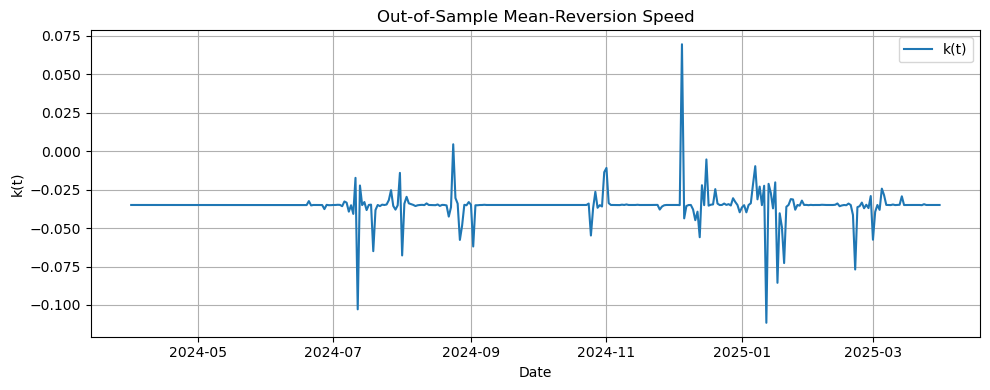

                   k
date                
2024-04-01 -0.034992
2024-04-02 -0.034992
2024-04-03 -0.034992
2024-04-04 -0.034992
2024-04-05 -0.034992
                   k
date                
2025-03-27 -0.034992
2025-03-28 -0.035010
2025-03-29 -0.034992
2025-03-30 -0.035011
2025-03-31 -0.034992


In [6]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from WA_mean_reversion_speed import WaveletNetwork

# 1) Load the checkpoint & rebuild the model
ckpt = torch.load("wavelet_meanrev_checkpoint.pth", map_location="cpu")
lags       = ckpt['lags']
hidden_dim = ckpt['hidden_dim']
max_lags   = ckpt['max_lags']
state_dict = ckpt['model_state_dict']

wn = WaveletNetwork(input_dim=len(lags), hidden_dim=hidden_dim)
wn.load_state_dict(state_dict)
wn.eval()

# 2) Compute out‑of‑sample residuals
forecast_df['residual'] = (
    forecast_df['actual']
  - forecast_df['trend']
  - forecast_df['seasonal']
)

# ensure datetime index
if not isinstance(forecast_df.index, pd.DatetimeIndex):
    forecast_df = forecast_df.set_index('date')

resid_forecast = forecast_df['residual']

# 3) Build lagged matrix (shift by i+1!)
df_lags = pd.concat(
    { f"lag_{i}": resid_forecast.shift(i+1) for i in range(max_lags) },
    axis=1
).dropna()

# 4) Select the columns your model needs
col_names = [f"lag_{i}" for i in lags]
Xf = df_lags[col_names].astype(np.float32).values
Xf_t = torch.from_numpy(Xf)

# 5) Get k(t) = a1(t) - 1
coefs_out = wn.partial_coefs(Xf_t).numpy()
k_out     = coefs_out[:, 0] - 1

# 6) Turn into a pandas Series indexed by the valid dates
k_series = pd.Series(k_out, index=df_lags.index, name='k')

# 7) Directly align onto forecast_df
forecast_df['k'] = k_series.reindex(forecast_df.index)
forecast_df['k'].fillna(method='bfill', inplace=True)

# 8) (Optional) Plot to verify
plt.figure(figsize=(10,4))
plt.plot(forecast_df.index, forecast_df['k'], label="k(t)")
plt.title("Out‑of‑Sample Mean‑Reversion Speed")
plt.xlabel("Date")
plt.ylabel("k(t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Quick check
print(forecast_df[['k']].head())
print(forecast_df[['k']].tail())

In [7]:
print(forecast_df.head())
print(forecast_df.tail())

                t      trend  seasonal forecast  actual  residual         k
date                                                                       
2024-04-01  27112  18.230617 -1.472498      NaN  12.000 -4.758119 -0.034992
2024-04-02  27113  18.230653 -1.353722      NaN  14.360 -2.516931 -0.034992
2024-04-03  27114  18.230689 -1.234349      NaN  14.055 -2.941340 -0.034992
2024-04-04  27115  18.230725 -1.114415      NaN  14.665 -2.451310 -0.034992
2024-04-05  27116  18.230762 -0.993955      NaN  10.195 -7.041807 -0.034992
                t      trend  seasonal forecast  actual  residual         k
date                                                                       
2025-03-27  27472  18.243677 -2.662236      NaN  15.195 -0.386441 -0.034992
2025-03-28  27473  18.243713 -2.547914      NaN  13.110 -2.585799 -0.035010
2025-03-29  27474  18.243749 -2.432784      NaN  13.165 -2.645965 -0.034992
2025-03-30  27475  18.243786 -2.316881      NaN  12.750 -3.176905 -0.035011
2025-03-31  

In [8]:
# 1) Make sure your index is datetime
if not isinstance(forecast_df.index, pd.DatetimeIndex):
    forecast_df['date'] = pd.to_datetime(forecast_df['date'])
    forecast_df = forecast_df.set_index('date')

# 2) Load your fitted sinusoid params
with open("variance_params.json", "r") as f:
    params = json.load(f)
# params = [c0, a1, b1, a2, b2, …]

# 3) Define a generic harmonics‐based variance forecast
def forecast_sigmaboy(doys, params):
    c0 = params[0]
    harmonics = np.array(params[1:]).reshape(-1, 2)  # each row = [a_i, b_i]
    sig2 = np.full_like(doys, fill_value=c0, dtype=float)
    for i, (ai, bi) in enumerate(harmonics, start=1):
        angle = 2 * np.pi * i * doys / 365
        sig2 += ai * np.cos(angle) + bi * np.sin(angle)
    return sig2

# 4) Compute day‐of‐year array for every forecast date
doys = forecast_df.index.dayofyear.to_numpy()  # e.g. [150, 151, 152, …]

# 5) Get σ^2 and then σ
sig2 = forecast_sigmaboy(doys, params)
forecast_df['sigmaboy'] = np.sqrt(np.maximum(sig2, 0.0))

# 6) Quick check
print(forecast_df[['sigmaboy']].head())

            sigmaboy
date                
2024-04-01  1.947462
2024-04-02  1.948087
2024-04-03  1.948665
2024-04-04  1.949195
2024-04-05  1.949674


In [9]:
print(forecast_df.head())
print(forecast_df.tail())

                t      trend  seasonal forecast  actual  residual         k  \
date                                                                          
2024-04-01  27112  18.230617 -1.472498      NaN  12.000 -4.758119 -0.034992   
2024-04-02  27113  18.230653 -1.353722      NaN  14.360 -2.516931 -0.034992   
2024-04-03  27114  18.230689 -1.234349      NaN  14.055 -2.941340 -0.034992   
2024-04-04  27115  18.230725 -1.114415      NaN  14.665 -2.451310 -0.034992   
2024-04-05  27116  18.230762 -0.993955      NaN  10.195 -7.041807 -0.034992   

            sigmaboy  
date                  
2024-04-01  1.947462  
2024-04-02  1.948087  
2024-04-03  1.948665  
2024-04-04  1.949195  
2024-04-05  1.949674  
                t      trend  seasonal forecast  actual  residual         k  \
date                                                                          
2025-03-27  27472  18.243677 -2.662236      NaN  15.195 -0.386441 -0.034992   
2025-03-28  27473  18.243713 -2.547914      NaN 

Mean Absolute Error (MAE): 2.5228866374898065
Mean Squared Error (MSE): 10.009364400738717
Root Mean Squared Error (RMSE): 3.16375795546036
Correlation Coefficient: 0.8708301142635118


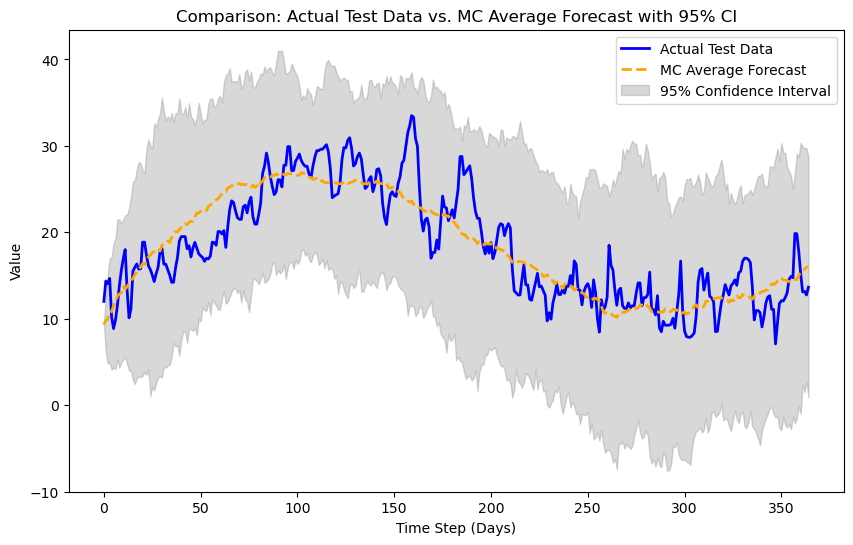

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Existing Monte Carlo simulation code ---
n_paths = 100                      # Number of Monte Carlo simulation paths

# Assume forecast_end, T_actual_train, T_actual_test, and forecast_df are defined elsewhere
# For example, T_actual_train and T_actual_test could be numpy arrays, and forecast_df a DataFrame

# Initialize forecasts: start with the last actual observation from training data.
T_all = np.zeros((n_paths, forecast_end))
T_all[:, 0] = T_actual_train[-1]

# Rolling forecast using actual data when available
for t in range(1, forecast_end):
    eps = np.random.randn(n_paths)  # random shock for each simulation path
    
    previous_value = T_all[:, t-1]
    T_all[:, t] = (previous_value  
                   + forecast_df['trend'].iloc[t] - forecast_df['trend'].iloc[t-1] 
                   + forecast_df['seasonal'].iloc[t] - forecast_df['seasonal'].iloc[t-1]  
                   + forecast_df['k'].iloc[t] * (previous_value - forecast_df['seasonal'].iloc[t-1] - forecast_df['trend'].iloc[t-1]) 
                   + forecast_df['sigmaboy'].iloc[t-1]*eps
    )


# Calculate the average forecast over all simulation paths.
T_avg = np.mean(T_all, axis=0)

# --- Compute error statistics between T_avg and T_actual_test ---
mae = mean_absolute_error(T_actual_test, T_avg)
mse = mean_squared_error(T_actual_test, T_avg)
rmse = np.sqrt(mse)
corr_coef = np.corrcoef(T_actual_test, T_avg)[0, 1]

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Correlation Coefficient:", corr_coef)

# --- Plot the Actual Test Data vs. MC Average Forecast with Confidence Interval ---
# Compute confidence interval bounds from the Monte Carlo simulation:
# For a 95% confidence interval, get the 2.5th and 97.5th percentiles.
lower_ci = np.percentile(T_all, 2.5, axis=0)
upper_ci = np.percentile(T_all, 97.5, axis=0)

plt.figure(figsize=(10, 6))

# Assuming T_actual_test and T_avg have the same length as forecast_end.
time_steps = np.arange(forecast_end)  # or adjust as needed

# Plot actual test data and average forecast
plt.plot(time_steps, T_actual_test, label="Actual Test Data", linewidth=2, color='blue')
plt.plot(time_steps, T_avg, label="MC Average Forecast", linewidth=2, linestyle="--", color='orange')

# Add the confidence interval as a shaded area.
plt.fill_between(time_steps, lower_ci, upper_ci, color='gray', alpha=0.3, label='95% Confidence Interval')

plt.xlabel("Time Step (Days)")
plt.ylabel("Value")
plt.title("Comparison: Actual Test Data vs. MC Average Forecast with 95% CI")
plt.legend()
plt.show()

In [ ]:
print(np.isnan(T_actual_test).sum())  # Number of NaNs in T_actual_test
print(np.isnan(T_avg).sum())          # Number of NaNs in T_avg

0
0


Mean Absolute Error (MAE): 1.1704623969598251
Mean Squared Error (MSE): 2.5170635128853562
Root Mean Squared Error (RMSE): 1.5865256105355994
Correlation Coefficient: 0.9692660558056969


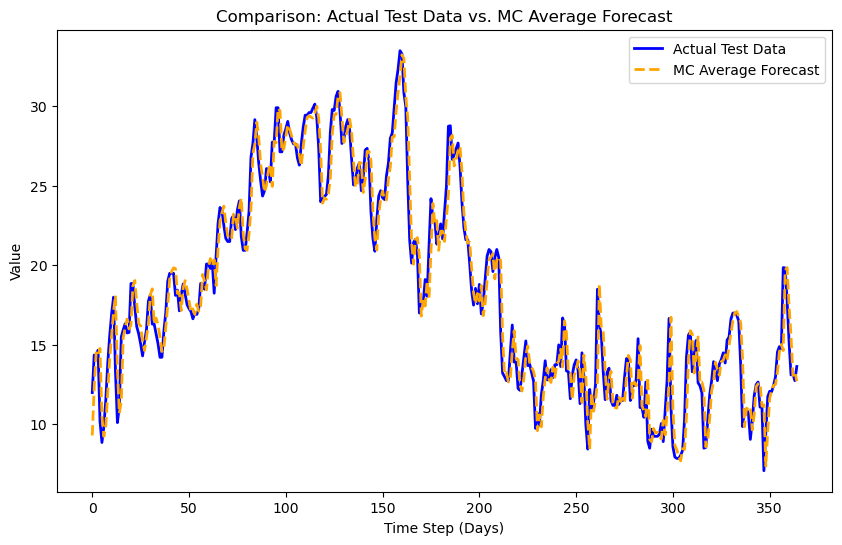

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

n_paths = 100     # number of Monte Carlo simulation paths

# Initialize forecasts: start with the last actual observation from training data.
T_all = np.zeros((n_paths, forecast_end))
T_all[:, 0] = T_actual_train[-1]

# Rolling forecast using actual data when available
for t in range(1, forecast_end):
    eps = np.random.randn(n_paths)  # random shock for each simulation path
    
    # Use the actual observed data at t-1 if available, otherwise fall back on the simulation
    if t-1 < len(T_actual_test):
        previous_value = T_actual_test[t-1]
    else:
        # If actual data is not available (e.g., beyond the test sample), you may use the forecasted average:
        previous_value = np.mean(T_all[:, t-1])
    
    # Compute the forecast for time t based on the actual observation at t-1.
    T_all[:, t] = (previous_value  
                   + forecast_df['trend'].iloc[t] - forecast_df['trend'].iloc[t-1] 
                   + forecast_df['seasonal'].iloc[t] - forecast_df['seasonal'].iloc[t-1]  
                   + forecast_df['k'].iloc[t] * (previous_value - forecast_df['seasonal'].iloc[t-1] - forecast_df['trend'].iloc[t-1]) 
                   + forecast_df['sigmaboy'].iloc[t-1]*eps
    )

# Calculate the average forecast over all simulation paths.
T_avg = np.mean(T_all, axis=0)

# -- Compute error statistics between T_avg and T_actual_test --
mae = mean_absolute_error(T_actual_test, T_avg)
mse = mean_squared_error(T_actual_test, T_avg)
rmse = np.sqrt(mse)
corr_coef = np.corrcoef(T_actual_test, T_avg)[0, 1]

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Correlation Coefficient:", corr_coef)

# -- Plot the Actual Test Data vs. MC Average Forecast --
plt.figure(figsize=(10, 6))
plt.plot(T_actual_test, label="Actual Test Data", linewidth=2, color='blue')
plt.plot(T_avg, label="MC Average Forecast", linewidth=2, linestyle="--", color='orange')
plt.xlabel("Time Step (Days)")
plt.ylabel("Value")
plt.title("Comparison: Actual Test Data vs. MC Average Forecast")
plt.legend()
plt.show()